In [1]:
import re
import time
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error
import math
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBClassifier, plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, LogisticRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

import Task_data_handler as Th

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Determining number of values
# training = pd.read_csv('ML5G-PS-005/ML5G-PS-005_train.csv')
# test = pd.read_csv('ML5G-PS-005/ML5G-PS-005_test.csv')

# numbers = []
# for i in range(len(training)):
#     if training.iloc[i]['amf.amf.app.five-g.RM.RegInitFail'] not in numbers:
#         numbers.append(training.iloc[i]['amf.amf.app.five-g.RM.RegInitFail'])

# for i in range(len(test)):
#     if test.iloc[i]['amf.amf.app.five-g.RM.RegInitFail'] not in numbers:
#         numbers.append(test.iloc[i]['amf.amf.app.five-g.RM.RegInitFail'])
# numbers.sort()
# print(numbers)

In [26]:
time_t = 10
df, target, label, train_size = Th.get_df_preprocessed(time_limit=time_t)
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) # to avoid column name error
print(df.shape, target.shape, label.shape, train_size)

(900, 3325) (900,) (900,) 600


In [27]:
X_train, y_train, X_test, y_test, train_label, test_label = Th.split(df, target, label, train_size)
print(X_train.shape, X_test.shape, train_label.shape)

(600, 3325) (300, 3325) (600,)


In [28]:
normal_data = pd.DataFrame(columns=['Detection time', 'amf.amf.app.five-g.RM.RegInitFail'])
abnormal_data = pd.DataFrame(columns=['Detection time', 'amf.amf.app.five-g.RM.RegInitFail'])


# for i in range(8, 21):
#     time_t = i
#     df, target, label, train_size = Th.get_df_preprocessed(time_limit=time_t)
#     df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
#     X_train, y_train, X_test, y_test, train_label, test_label = Th.split(df, target, label, train_size)


for i in range(len(X_train)):
    tmp_df = pd.DataFrame([[time_t, y_train.iloc[i]]], 
        columns=['Detection time', 'amf.amf.app.five-g.RM.RegInitFail'])
    if train_label.iloc[i] == 'normal':
        normal_data = pd.concat([normal_data, tmp_df], ignore_index=True)
    else:
        abnormal_data = pd.concat([abnormal_data, tmp_df], ignore_index=True)
print(time_t)
print('normal: {}      abnormal: {}'.format(len(normal_data), len(abnormal_data)))

10
normal: 450      abnormal: 150


In [29]:
normal_data.describe()
# normal_data = normal_data.sort_values('amf.amf.app.five-g.RM.RegInitFail', ascending=False)

,amf.amf.app.five-g.RM.RegInitFail
count,450.000000
mean,0.900000
std,1.287684
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,9.000000


In [30]:
abnormal_data.describe()
# abnormal_data = abnormal_data.sort_values('amf.amf.app.five-g.RM.RegInitFail', ascending=False)

,amf.amf.app.five-g.RM.RegInitFail
count,150.000000
mean,1.000000
std,1.331094
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,8.000000


In [31]:
# sns.lineplot(x=abnormal_data['Detection time'], y=abnormal_data['amf.amf.app.five-g.RM.RegInitFail'], label='abnormal', color='red');
# sns.lineplot(x=normal_data['Detection time'], y=normal_data['amf.amf.app.five-g.RM.RegInitFail'], color='green', label='Normal');
# plt.legend(loc='upper left')
# plt.title('Target Variable against detection time for normal and abnormal');
# plt.show()

In [32]:
X_train, train_label, y_train = Th.manage_imbalance(X_train, train_label, y_train)
print(X_train.shape, train_label.shape, y_train.shape)

(900, 3325) (900, 1) (900,)


# Model

In [33]:
le = LabelEncoder()
svr_model = SVR(C=0.09, kernel='sigmoid')
bayes_model = BayesianRidge()
cat_model = CatBoostRegressor()
xgbr_model = XGBRegressor()
random_forest_model = RandomForestRegressor()

svr_model.fit(X_train, y_train)
bayes_model.fit(X_train, y_train)
xgbr_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train, verbose=250)

Learning rate set to 0.040267
0:	learn: 1.1790341	total: 257ms	remaining: 4m 16s
250:	learn: 0.4725515	total: 46.6s	remaining: 2m 19s
500:	learn: 0.2073539	total: 1m 34s	remaining: 1m 34s
750:	learn: 0.1052676	total: 2m 25s	remaining: 48.4s
999:	learn: 0.0529713	total: 3m 17s	remaining: 0us


In [34]:
def my_pred(pred, threshold=2):
    return (pred >= threshold).astype(int)

In [35]:
y = test_label.factorize()[0]
models ={ 
        'SVR': svr_model, 
        'Cat': cat_model,
        'XGBR' : xgbr_model,
        'Bayesian Ridge' : bayes_model,
        'Random Forest': random_forest_model,
}

min_threshold = 0
max_threshold = 100
steps = 1
if time_t < 150:
        max_threshold = 300
        steps = 100
elif time_t == 30:      
        min_threshold = 0
        max_threshold = 3000
        steps = 1000
        
min_threshold = 0
max_threshold = 3000
steps = 1000

results = pd.DataFrame(columns=['Model', 'F1', 'Threshold', 'Accurancy'])
for i in range(min_threshold, max_threshold):
    for name, model in models.items():
        pred = my_pred(model.predict(X_test), threshold=i/steps)
        accur = accuracy_score(y, pred)
        tmp_df = pd.DataFrame([[name, f1_score(y, pred, average=None)[0], i/steps, accur]], columns=['Model', 'F1', 'Threshold', 'Accurancy'])
        results = pd.concat([results, tmp_df], ignore_index=True)
results = results.sort_values(by=['F1', 'Accurancy'], ascending = [False, False])

In [ ]:
# Write a Summary of the findings for recording purposes
print('Detection time:', time_t)
top_models = []
summary = pd.DataFrame(columns=['Model', 'F1', 'Threshold', 'Accurancy'])
i = 0
while len(top_models) < len(models):
    if results.iloc[i]['Model'] not in top_models:
        accur = accuracy_score(y, my_pred(svr_model.predict(X_test), threshold=results.iloc[i]['Threshold']))
        tmp_df = pd.DataFrame([[results.iloc[i]['Model'], results.iloc[i]['F1'], results.iloc[i]['Threshold'], accur]], 
            columns=['Model', 'F1', 'Threshold', 'Accurancy'])
        summary = pd.concat([summary, tmp_df], ignore_index=True)
        top_models.append(results.iloc[i]['Model'])

        if results.iloc[i]['Model'] == 'SVR':
            threshold = results.iloc[i]['Threshold']
    i += 1
summary

Detection time: 15


,Model,F1,Threshold,Accurancy
0,SVR,0.869396,0.513,0.776667
1,Bayesian Ridge,0.857143,2.177,0.750000
2,Random Forest,0.857143,2.624,0.750000
3,XGBR,0.857143,2.686,0.750000
4,Cat,0.854962,2.446,0.750000


In [ ]:
mse = mean_squared_error(y, my_pred(svr_model.predict(X_test), threshold=threshold))  
rmse = math.sqrt(mse)


my_rms = np.square(np.subtract(y, my_pred(svr_model.predict(X_test), threshold=threshold))).mean()   
my_rmse = math.sqrt(my_rms) 

print('sklearn RMSE:', rmse, 'My RMSE:', my_rmse)

sklearn RMSE: 0.47258156262526085 My RMSE: 0.47258156262526085


In [ ]:
# Write details of the findings
pd.set_option('display.max_rows', 20)
print('Detected time:', time_t)
results

Detected time: 15


,Model,F1,Threshold,Accurancy
2565,SVR,0.869396,0.513,0.776667
2570,SVR,0.869396,0.514,0.776667
2575,SVR,0.869396,0.515,0.776667
2640,SVR,0.868217,0.528,0.773333
2645,SVR,0.868217,0.529,0.773333
...,...,...,...,...
2699,Random Forest,0.000000,0.539,0.250000
2704,Random Forest,0.000000,0.540,0.250000
2709,Random Forest,0.000000,0.541,0.250000
2714,Random Forest,0.000000,0.542,0.250000


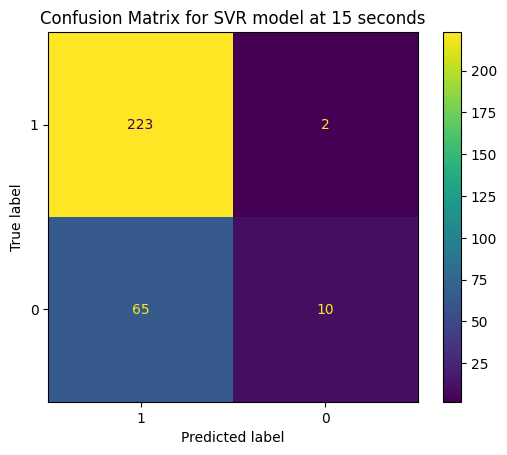

In [ ]:
# plt.figure(figsize=(10,7))
# sns.set(font_scale=1.4) # for label size
# sns.heatmap(confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold)), annot=True, annot_kws={"size": 16}, cmap='RdYlBu_r', fmt='g')
# plt.xlabel('Actual labels')
# plt.ylabel('Predicted labels')
# plt.title('Confusion Matrix')
# plt.show()


import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

cm = confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [1, 0], )
cm_display.plot()
plt.title(f'Confusion Matrix for SVR model at {time_t} seconds')
plt.show()

In [ ]:
# Compare sklearn F1-Score calculations with my implememtation
def recall(matrix):
    [tp, fp], [fn, tn] = matrix
    return tp/(tp+fp)

def precision(matrix):
    [tp, fp], [fn, tn] = matrix
    return tp/(tp+fn)

def f1(matrix):
    return 2 * precision(matrix) * recall(matrix)/(precision(matrix)+recall(matrix))

print('Precision: ', precision(confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))))
print('Recall:    ', recall(confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))))
print('My implementation F1:   ', f1(confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))))
print('Sklearn implementation: ', f1_score(y, my_pred(svr_model.predict(X_test), threshold=threshold), average=None)[0])


Precision:  0.7743055555555556
Recall:     0.9911111111111112
My implementation F1:    0.8693957115009747
Sklearn implementation:  0.8693957115009747


In [ ]:
print(classification_report(y, my_pred(svr_model.predict(X_test), threshold=threshold)))

              precision    recall  f1-score   support

           0       0.77      0.99      0.87       225
           1       0.83      0.13      0.23        75

    accuracy                           0.78       300
   macro avg       0.80      0.56      0.55       300
weighted avg       0.79      0.78      0.71       300

